In [91]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
import ast

In [92]:
# Load data
df = pd.read_csv("S10-M_position_analysis_1127_Strict_version.csv")

# Columns
TEXT_COL = "Embedding Units"
SPEAKER_COL = "Speaker Turn"
ORDER_COL = "Position ID" if "Position ID" in df.columns else None
agent_id = "P3"  # agent speaker label


In [93]:
df_full = df.copy()

In [94]:
def parse_units(x):
    if isinstance(x, str) and x.strip():
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

In [95]:
df_full["Embedding Units"] = df_full["Embedding Units"].apply(parse_units)

In [96]:
def extract_subpositions(units):
    return [u["unit"] for u in units if "unit" in u]

In [97]:
df_full["SubPositions"] = df_full["Embedding Units"].apply(extract_subpositions)

In [98]:
df_content = df_full[df_full["HasContent"] == True].copy()
df_content.reset_index(drop=True, inplace=True)

In [99]:
df_content.shape

(25, 10)

In [100]:
df_content.head(2)

,Position ID,Speaker,Text,Position (full),Sub-positions,Embedding Units,HasContent,Focus Topic,Rationale,SubPositions
0,2,P1,Yeah. Let's go for it. So it seems like we've ...,P1 believes that the global citizenship progra...,['The program aims to help students understand...,[{'unit': 'The program aims to help students u...,True,global citizenship program,P1 discusses the importance of the global citi...,[The program aims to help students understand ...
1,3,P2,Yeah. I completely agree. I think a big part o...,P2 believes that travel is essential for inter...,['Intercultural collaboration is a key aspect ...,[{'unit': 'Intercultural collaboration is a ke...,True,intercultural collaboration and travel in educ...,P2 expresses agreement with the importance of ...,[Intercultural collaboration is a key aspect o...


In [101]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [102]:
def embed(text):
    return model.encode(text)

In [103]:
rows = []
for idx, row in df_content.iterrows():
    for sp in row["SubPositions"]:
        rows.append({
            "Position ID": row["Position ID"],
            "Speaker": row["Speaker"],
            "SubPosition": sp
        })

subs = pd.DataFrame(rows)

In [104]:
subs["Embedding"] = subs["SubPosition"].apply(embed)

In [106]:
turn_vectors = subs.groupby("Position ID")["Embedding"].apply(
    lambda vecs: np.mean(list(vecs), axis=0)
)

df_content["SubPosEmbedding"] = df_content["Position ID"].map(turn_vectors)

In [107]:
df_content["PositionEmbedding"] = df_content["Position (full)"].apply(embed)

In [109]:
df_content.to_csv("S10-M_content_df.csv", index = False)

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import MDS
import numpy as np

def mds_project(vectors):
    vecs = np.vstack(vectors)
    dist = cosine_distances(vecs)
    m = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = m.fit_transform(dist)
    return coords

# Version A：position-level
pos_coords = mds_project(df_content["PositionEmbedding"].values)
df_content["pos_x"], df_content["pos_y"] = pos_coords[:,0], pos_coords[:,1]

# Version B：sub-position-level
sub_coords = mds_project(df_content["SubPosEmbedding"].values)
df_content["sub_x"], df_content["sub_y"] = sub_coords[:,0], sub_coords[:,1]


/home/always1020/anaconda3/envs/si618/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/home/always1020/anaconda3/envs/si618/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [79]:
def draw_cluster_plot(df, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(10,8))

    colors = {"P1": "#4A90E2", "P2": "#7ED321", "P3": "#9013FE"}

    for spk in ["P1", "P2", "P3"]:
        tmp = df[df["Speaker"] == spk]
        x, y = tmp[x_col], tmp[y_col]

        # utterance scatter
        ax.scatter(x, y, c=colors[spk], s=60, alpha=0.6, label=f"{spk} utterances")

        # ellipse
        draw_ellipse(x, y, ax, colors[spk])

        # start → end arrow
        if len(x) >= 2:
            xs, ys = x.iloc[0], y.iloc[0]
            xe, ye = x.iloc[-1], y.iloc[-1]
            ax.scatter(xs, ys, c=colors[spk], s=150, marker="o")
            ax.scatter(xe, ye, c=colors[spk], s=200, marker="*", edgecolor="black")
            ax.arrow(xs, ys, xe-xs, ye-ys, color=colors[spk],
                     alpha=0.9, head_width=0.02, length_includes_head=True)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()


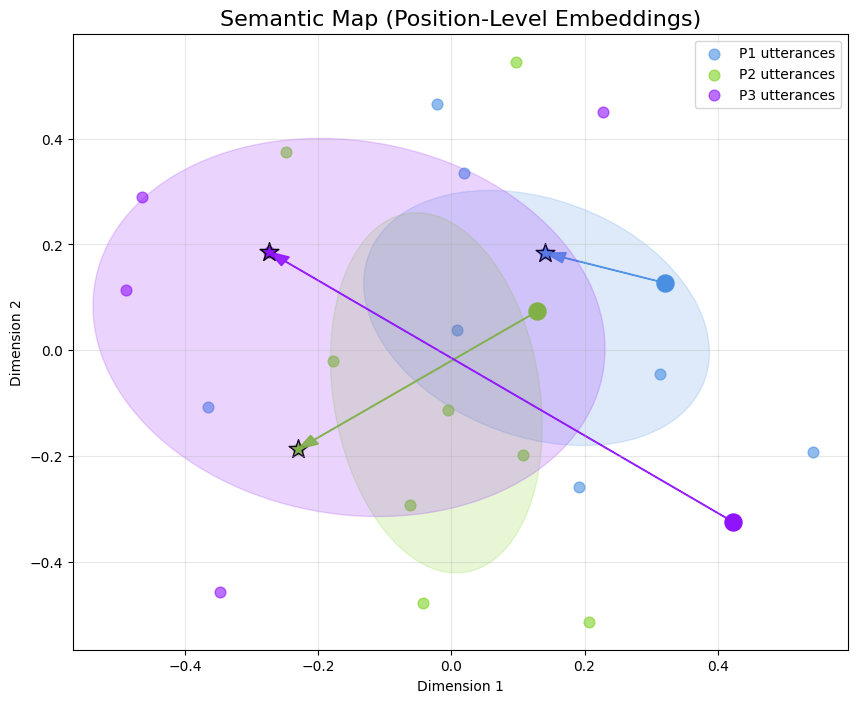

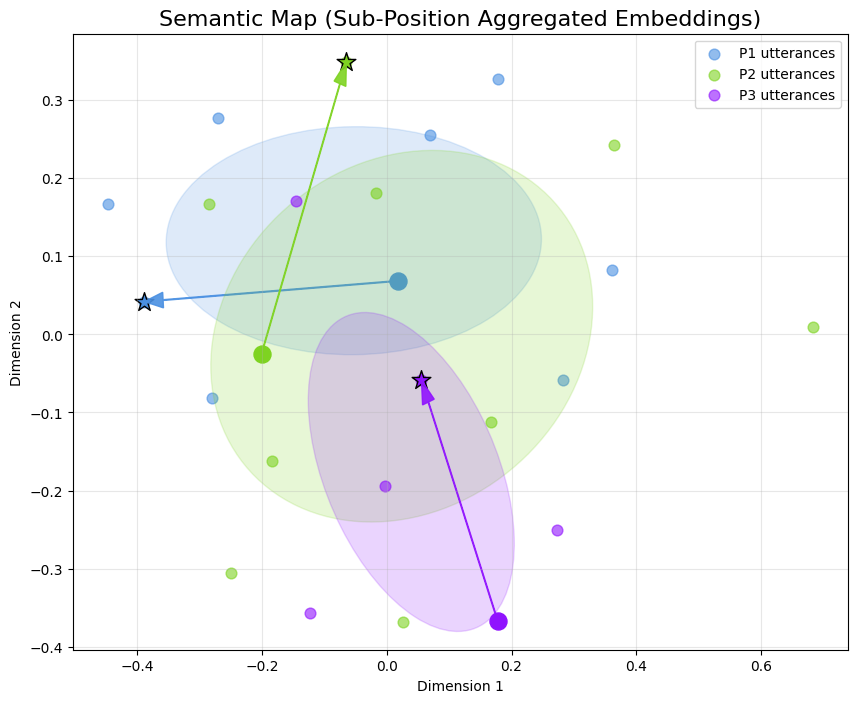

In [ ]:
draw_cluster_plot(df_content, "pos_x", "pos_y",
                    "Semantic Map (Position-Level Embeddings)")

draw_cluster_plot(df_content, "sub_x", "sub_y",
                    "Semantic Map (Sub-Position Aggregated Embeddings)")


In [85]:
def get_fragment_trajectory(start_turn, end_turn):
    frag = df_content[(df_content["Position ID"] >= start_turn) &
                        (df_content["Position ID"] <= end_turn)]

    if len(frag) == 0:
        return None
    
    vecs = np.vstack(frag["SubPosEmbedding"].values)
    dist = cosine_distances(vecs)
    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(dist)
    
    frag = frag.copy()
    frag["x"] = coords[:,0]
    frag["y"] = coords[:,1]
    
    return frag

In [86]:
def draw_ellipse(x, y, ax, color, alpha=0.18):
    x = np.array(x); y = np.array(y)
    if len(x) < 2:
        return
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2*np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                    width=width, height=height,
                    angle=theta, edgecolor=color,
                    facecolor=color, alpha=alpha)
    ax.add_patch(ell)

In [87]:
def plot_fragment_trajectory(start_turn, end_turn):
    frag = get_fragment_trajectory(start_turn, end_turn)
    if frag is None:
        print("No meaningful turns in this range.")
        return
    
    colors = {"P1":"#4A90E2", "P2":"#7ED321", "P3":"#9013FE"}
    fig, ax = plt.subplots(figsize=(10,8))
    
    for spk in frag["Speaker"].unique():
        df_spk = frag[frag["Speaker"] == spk]
        x, y = df_spk["x"], df_spk["y"]
        
        # scatter
        ax.scatter(x, y, s=80, c=colors.get(spk, "gray"),
                    label=spk, alpha=0.7)
        
        # start / end
        if len(x) >= 2:
            ax.scatter(x.iloc[0], y.iloc[0], c=colors[spk],
                        s=150, marker="o", edgecolor="black")
            ax.scatter(x.iloc[-1], y.iloc[-1], c=colors[spk],
                        s=200, marker="*", edgecolor="black")
            ax.arrow(x.iloc[0], y.iloc[0],
                        x.iloc[-1] - x.iloc[0],
                        y.iloc[-1] - y.iloc[0],
                        color=colors[spk], head_width=0.02, alpha=0.9)
        
        # ellipse
        draw_ellipse(x, y, ax, colors[spk])

    ax.set_title(f"Trajectory for Turns {start_turn}-{end_turn}", fontsize=16)
    ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.show()

/home/always1020/anaconda3/envs/si618/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


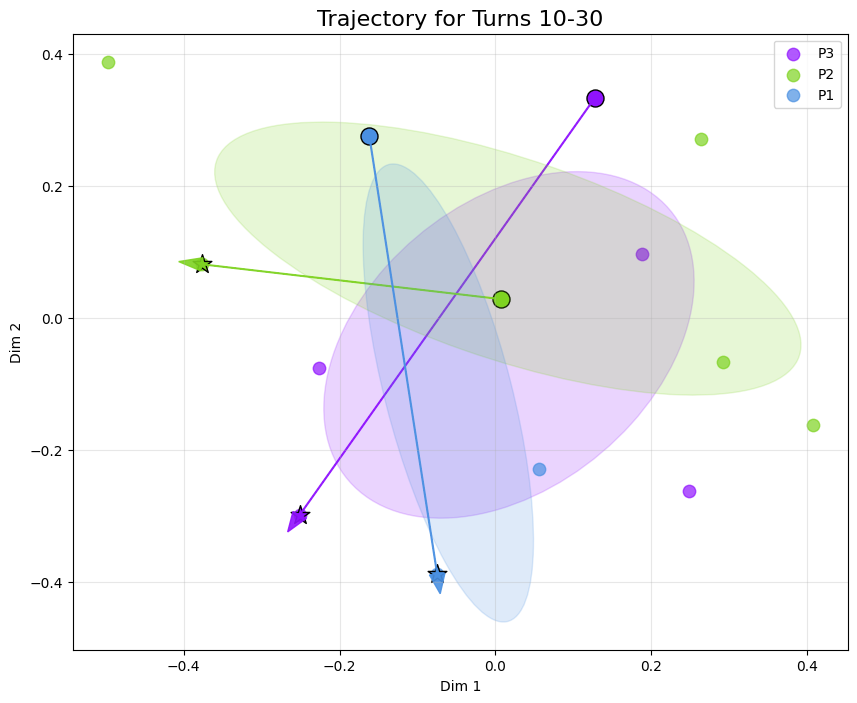

In [89]:
plot_fragment_trajectory(10, 30)